In [1]:
import h5py as h5

import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

from scipy.ndimage import maximum_filter, median_filter, gaussian_filter
from skimage.measure import label, regionprops

plt.set_cmap("viridis")
plt.close()

In [2]:
#load HRSTEM image data and metadata
with h5.File(f'../data/HRSTEM.h5','r') as h5file:
    img = h5file['data'][:].astype(np.float32)
    metadata = {key: h5file['data'].attrs[key] for key in h5file['data'].attrs}

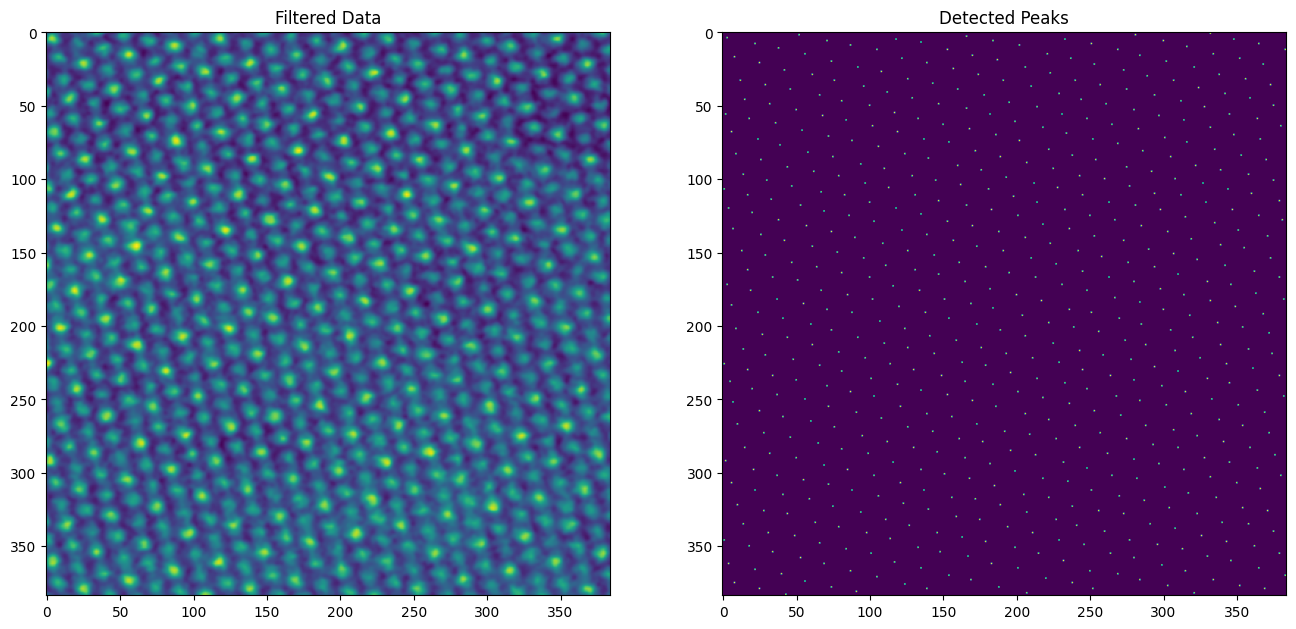

In [3]:
#some peaks do not show up due to monitor/aliasing/display artefacts

filtered_img=median_filter(img,3)
filtered_img=gaussian_filter(filtered_img,1,mode='constant')

#local region to detect peaks
neighborhood = np.ones((10,10)).astype(bool)
detected_peaks = (maximum_filter(filtered_img, footprint=neighborhood)==filtered_img).astype(np.int32)


#verifying that all detected peaks are a single pixel and finding locations
peak_locations = []
label_image = label(detected_peaks)
for region in regionprops(label_image):
    assert region.area == 1
    peak_locations.append(region.centroid)

#plotting result
fig,ax =plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(filtered_img[128:512,128:512])
ax[0].set_title("Filtered Data")
ax[1].imshow(detected_peaks[128:512,128:512])
ax[1].set_title("Detected Peaks")

plt.show()

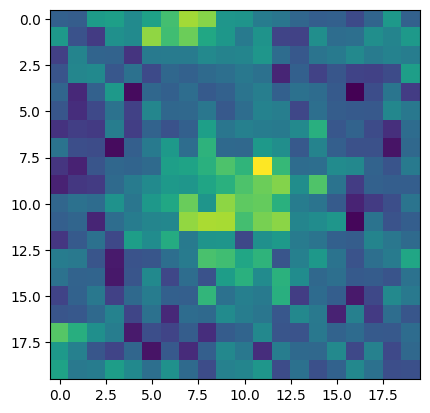

In [4]:
#manually finding optimal size for fitting region.

peak_num = np.random.randint(0,len(peak_locations))
temp_center_x = peak_locations[peak_num][0]
temp_center_y = peak_locations[peak_num][1]

fit_window = 20

plt.imshow(img[int(temp_center_x-fit_window/2):int(temp_center_x+fit_window/2),
                 int(temp_center_y-fit_window/2):int(temp_center_y+fit_window/2)])
plt.show()

In [5]:
error_list = []
fit_list=[]
#params: Amplitude, center_X, center_Y, sigma_X, sigma_Y, angle, offset
bounds=((0.,0.,0.,0.,0.,-180,-2**16),(1e7,fit_window,fit_window,fit_window,fit_window,180,2**16))

#function for fitting 2d peaks
def gaussian2D(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)         
                        + c*((y-yo)**2)))                                   
    return g.ravel()

CROP_AMOUNT = 24
#location of atoms in image
fit_peaks = []
for x in range(CROP_AMOUNT,len(img[0])-CROP_AMOUNT):
    for y in range(CROP_AMOUNT,len(img)-CROP_AMOUNT):
        if detected_peaks[y,x]:
            fit_peaks.append((x,y))
            
np.random.seed(100)
for peak in tqdm.tqdm(fit_peaks):
    x,y = peak[0],peak[1]
    try:
        dataforfit=img[int(y-fit_window/2):int(y+fit_window/2),int(x-fit_window/2):int(x+fit_window/2)]
        xp = np.arange(0, len(dataforfit[0]), 1)
        yp = np.arange(0, len(dataforfit), 1)
        xp,yp = np.meshgrid(xp, yp)
        #params: Amplitude, center_X, center_Y, sigma_X, sigma_Y, angle, offset
        p0 = [dataforfit.max(),len(dataforfit)/2,len(dataforfit)/2,4.,4.,50.,dataforfit.min()]
        #parameter estimation/initialization
        coeff, var_matrix = curve_fit(gaussian2D, (xp, yp), dataforfit.ravel(), p0=p0,bounds=bounds, maxfev=8000)
        fit_list.append(coeff)
    
    except Exception as e:
        error_list.append((x,y))

print(f'{len(fit_list)} fits successful.')
print(f'{len(error_list)} fits failed.')    

  0%|          | 0/4026 [00:00<?, ?it/s]

4026 fits successful.
0 fits failed.


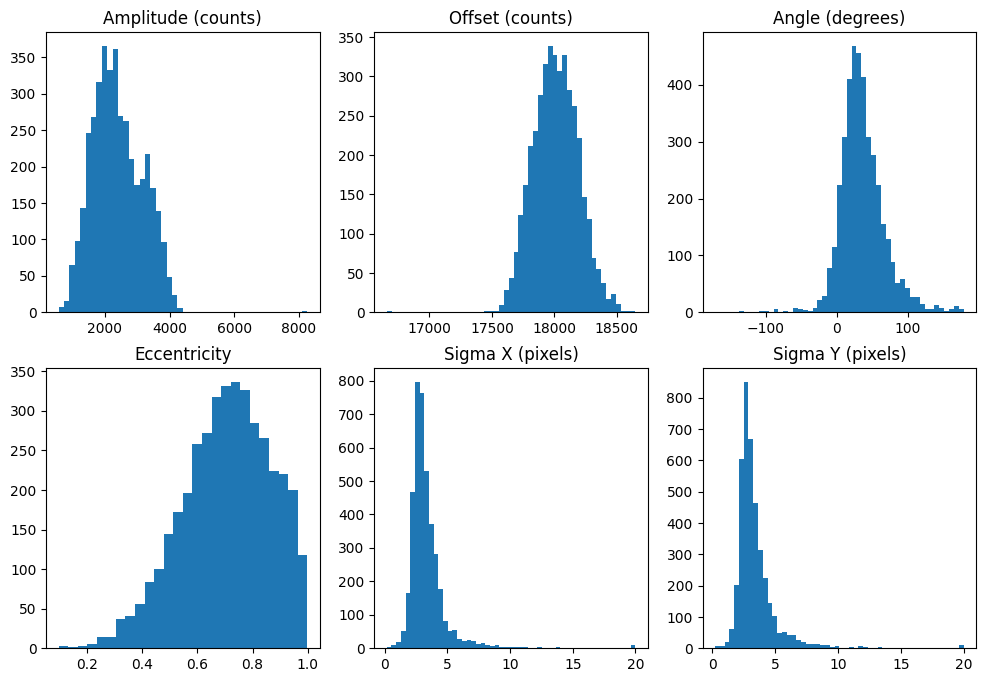

In [6]:
#Visual summary of peak fitting results
all_data = np.transpose(fit_list)

fig,ax =plt.subplots(2,3,figsize=(12,8))

ax[0,0].hist(all_data[0],bins='scott')
ax[0,0].set_title('Amplitude (counts)')

ax[0,1].hist(all_data[-1],bins='scott')
ax[0,1].set_title('Offset (counts)')

ax[0,2].hist(all_data[5],bins='scott')
ax[0,2].set_title('Angle (degrees)')

ecc1 = all_data[3]**2/all_data[4]**2
ecc2 = 1/ecc1
ecc = np.min([ecc1,ecc2],axis=0)
ecc = np.sqrt(1-ecc)

ax[1,0].hist(ecc,bins='scott')
ax[1,0].set_title('Eccentricity')

ax[1,1].hist(all_data[3],bins='scott')
ax[1,1].set_title('Sigma X (pixels)')

ax[1,2].hist(all_data[4],bins='scott')
ax[1,2].set_title('Sigma Y (pixels)')

plt.show()


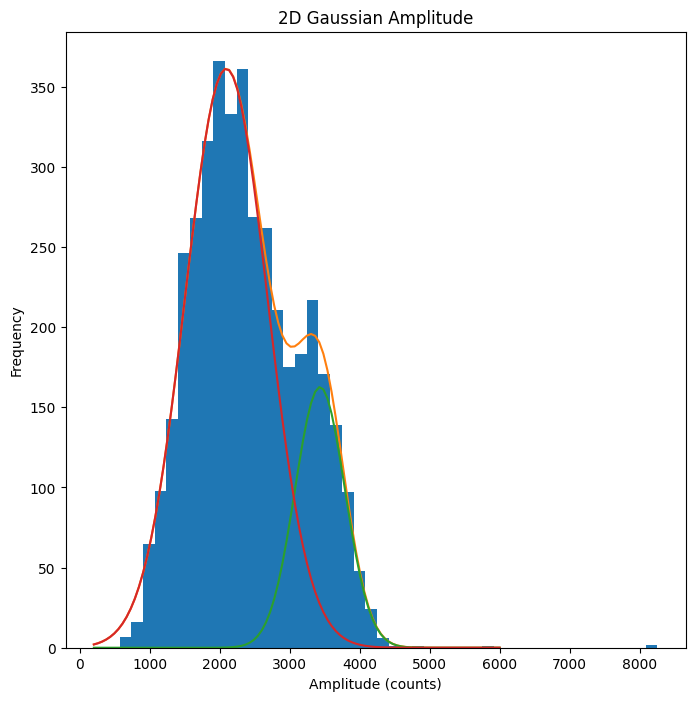

Amplitude Ratio (Z-Contrast): 1.6402701206662789
Center Ratio (Lattice Geometry): 2.2205283814637427


In [7]:
#Two gaussian fitting to bimodal amplitude

data = np.histogram(all_data[0],bins='scott')

def double_gaussian(xx,a0,a1,x0,x1,s0,s1):
    return a0*np.exp(-(xx-x0)**2/(2*s0**2)) + a1*np.exp(-(xx-x1)**2/(2*s1**2))

p0 = [data[0].mean(),data[0].mean(),data[1].mean(),data[1].mean(),data[1].std(),data[1].std()]

bin_borders = data[1]
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

coeff, var_matrix = curve_fit(double_gaussian, bin_centers, data[0], p0=p0)

fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.hist(all_data[0],bins='scott')

xx = np.linspace(200,6000,100)

yy = double_gaussian(xx,*coeff)
y0 = coeff[0]*np.exp(-(xx-coeff[2])**2/(2*coeff[4]**2))
y1 = coeff[1]*np.exp(-(xx-coeff[3])**2/(2*coeff[5]**2))

ax.plot(xx,yy)
ax.plot(xx,y0)
ax.plot(xx,y1)

ax.set_title('2D Gaussian Amplitude')
ax.set_ylabel('Frequency')
ax.set_xlabel('Amplitude (counts)')

plt.show()

print('Amplitude Ratio (Z-Contrast): ' + str(np.max([coeff[2]/coeff[3],coeff[3]/coeff[2]])))
print('Center Ratio (Lattice Geometry): ' + str(np.max([coeff[0]/coeff[1],coeff[1]/coeff[0]])))